## Final v1

## Environment Setup

This cell installs the required libraries and imports the dependencies used throughout the project for model training, parameter-efficient fine-tuning, evaluation, and visualization.

In [ ]:
# Installing required libraries for model training, evaluation, and visualization
!pip install -q transformers peft datasets accelerate sentence-transformers seaborn

import torch
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, get_peft_model, TaskType
from sentence_transformers import SentenceTransformer, util

# Disabling warnings to keep output readable
warnings.filterwarnings('ignore')


## Evaluation Metrics

We evaluate model performance using two complementary metrics. ROUGE-L captures lexical overlap between the model's prediction and the reference answer using the longest common subsequence. We also use a semantic similarity metric based on cosine similarity between sentence embeddings to capture meaning-level similarity. These metrics are reported separately for medical question answering and general knowledge tasks

In [ ]:
print("Loading Semantic Evaluation Model...")
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_rouge_l(hypothesis, reference):
    # To compute ROUGE-L score based on the longest common subsequence (LCS) between the predicted output and the reference text.
    if not hypothesis or not reference:
        return 0.0
    hyp_tokens = str(hypothesis).lower().split()
    ref_tokens = str(reference).lower().split()
    if len(hyp_tokens) == 0 or len(ref_tokens) == 0:
        return 0.0

    m, n = len(hyp_tokens), len(ref_tokens)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if hyp_tokens[i - 1] == ref_tokens[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    lcs_len = dp[m][n]
    precision = lcs_len / len(hyp_tokens)
    recall = lcs_len / len(ref_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def calculate_semantic_score(hypothesis, reference):
    # To compute cosine similarity between sentence embeddings of the hypothesis and reference texts.
    if not hypothesis or not reference:
        return 0.0
    emb1 = semantic_model.encode(hypothesis, convert_to_tensor=True)
    emb2 = semantic_model.encode(reference, convert_to_tensor=True)
    return max(0.0, util.pytorch_cos_sim(emb1, emb2).item())

Loading Semantic Evaluation Model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Data Loading and Preprocessing

This section handles loading the medical dataset and converting structured symptom indicators into natural language descriptions. Binary symptom vectors are transformed into text prompts, which are used to fine-tune the language models. We also define a fixed set of general knowledge prompts to evaluate knowledge retention after fine-tuning.


In [ ]:
class MedicalDataPreprocessor:
    def __init__(self, csv_path):
        # Identifying the label and symptom columns from the dataset
        self.df = pd.read_csv(csv_path)
        self.label_col = 'diseases' if 'diseases' in self.df.columns else self.df.columns[0]
        self.symptom_cols = [col for col in self.df.columns if col != self.label_col]

    def binary_to_text(self, row):
        # Converting binary symptom indicators into a comma-separated text description
        symptoms = []
        for col in self.symptom_cols:
            try:
                if int(row[col]) != 0:
                    symptoms.append(str(col).strip())
            except:
                continue
        return ', '.join(symptoms) if symptoms else 'No symptoms'

    def preprocess(self):
        # Creating text-based symptom descriptions and normalizing disease labels
        self.df['symptoms_text'] = self.df.apply(self.binary_to_text, axis=1)
        self.df['diseases'] = self.df[self.label_col].astype(str).str.strip()
        return self.df

def get_general_prompts():
    # Using some fixed general knowledge prompts to evaluate knowledge retention
    return [
        ("The capital of France is", "Paris"),
        ("The largest planet in our solar system is", "Jupiter"),
        ("Water boils at 100 degrees", "Celsius"),
        ("The chemical symbol for Gold is", "Au"),
        ("Romeo and Juliet was written by", "William Shakespeare"),
        ("The fastest land animal is", "Cheetah"),
        ("The currency used in Japan is the", "Yen"),
        ("The color of a ripe banana is", "Yellow"),
        ("The opposite of hot is", "Cold"),
        ("A triangle has this many sides:", "Three"),
        ("The sun rises in the", "East"),
        ("The human body has 206", "bones"),
        ("The largest ocean on Earth is", "Pacific"),
        ("Bees produce this sweet substance:", "Honey"),
        ("The capital of the United States is", "Washington D.C."),
        ("Ice is the solid form of", "Water"),
        ("To bake a cake you generally need flour, sugar, and", "Eggs"),
        ("The Statue of Liberty is located in", "New York"),
        ("The first letter of the alphabet is", "A"),
        ("A year generally has this many days:", "365")
    ]

## LoRA Experiment Runner

This section defines the experimental framework used to fine-tune language models with LoRA.
We systematically vary LoRA rank, learning rate, and number of training epochs to study their effects on medical domain adaptation and catastrophic forgetting. The experiment runner supports both GPT-2 and TinyLlama architectures and evaluates performance on medical and general tasks.


In [ ]:
class LoRAExperiment:
    def __init__(self, csv_path='disease_symptoms.csv', device='cuda', model_name='gpt2'):
        self.device = device
        self.csv_path = csv_path
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def _get_target_modules(self):
        # Selecting LoRA target modules based on the model architecture
        if 'llama' in self.model_name.lower() or 'mistral' in self.model_name.lower():
            return ["q_proj", "k_proj", "v_proj", "o_proj"]
        elif 'gpt2' in self.model_name.lower():
            return ["c_attn", "c_proj", "c_fc"]
        else:
            # Default attention projection layers
            return ["q_proj", "k_proj", "v_proj", "o_proj"]
    def train_and_evaluate_lr(self, learning_rates=[1e-5, 1e-4, 3e-4, 5e-4]):
      print(f"Preparing Data for {self.model_name}...")
      try:
          preprocessor = MedicalDataPreprocessor(self.csv_path)
          full_df = preprocessor.preprocess()
          train_df = full_df.sample(n=4000, random_state=42)
          med_test_df = full_df.drop(train_df.index).sample(n=20, random_state=42)
      except FileNotFoundError:
          print("Error: CSV file not found!")
          return

      # Prompts
      train_prompts = train_df.apply(
          lambda x: f"### Symptoms: {x['symptoms_text']}\n### Disease: {x['diseases']}{self.tokenizer.eos_token}",
          axis=1
      ).tolist()

      med_test_input = med_test_df.apply(lambda x: f"### Symptoms: {x['symptoms_text']}\n### Disease:", axis=1).tolist()
      med_ground_truth = med_test_df['diseases'].tolist()

      gen_data = get_general_prompts()
      gen_input = [x[0] for x in gen_data]
      gen_truth = [x[1] for x in gen_data]

      results = []

      for lr in learning_rates:
          print(f"\n" + "="*60)
          print(f"  [{self.model_name.upper()}] TRAINING WITH LEARNING RATE: {lr}")
          print("="*60)

          if torch.cuda.is_available(): torch.cuda.empty_cache()

          base_model = AutoModelForCausalLM.from_pretrained(self.model_name).to(self.device)

          # Fixed LoRA config with rank=64
          config = LoraConfig(
              r=64,
              lora_alpha=128,
              target_modules=self._get_target_modules(),
              lora_dropout=0.05,
              bias='none',
              task_type=TaskType.CAUSAL_LM
          )
          model = get_peft_model(base_model, config)
          model.print_trainable_parameters()

          train_ds = Dataset.from_dict({'prompt': train_prompts})
          def tokenize(ex):
              tokenized = self.tokenizer(ex['prompt'], padding='max_length', truncation=True, max_length=128)
              tokenized['labels'] = tokenized['input_ids'].copy()
              return tokenized

          tokenized_ds = train_ds.map(tokenize, batched=True)

          training_args = TrainingArguments(
              # output_dir=f'./results_lr_{lr}',  # No output folders - just display charts
              num_train_epochs=3,
              per_device_train_batch_size=8,
              learning_rate=lr,  # Variable learning rate
              logging_steps=100,
              report_to="none",
              save_strategy="no",
              eval_strategy="no",
              use_cpu=False
          )

          trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_ds)
          trainer.train()

          model.eval()
          print(f"\n> Evaluating Learning Rate {lr}...")

          # Medical Evaluation
          med_semantic = []
          med_rouge_l = []
          with torch.no_grad():
              for p, truth in zip(med_test_input, med_ground_truth):
                  inputs = self.tokenizer(p, return_tensors="pt").to(self.device)
                  outputs = model.generate(**inputs, max_new_tokens=15, pad_token_id=self.tokenizer.eos_token_id, eos_token_id=self.tokenizer.eos_token_id)
                  decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                  if "### Disease:" in decoded:
                      res = decoded.split("### Disease:")[-1].strip()
                  else:
                      res = decoded.replace(p, "").strip()
                  res = res.split('\n')[0].strip()
                  med_semantic.append(calculate_semantic_score(res, truth))
                  med_rouge_l.append(calculate_rouge_l(res, truth))

          # General Evaluation
          gen_semantic = []
          gen_rouge_l = []
          with torch.no_grad():
              for p, truth in zip(gen_input, gen_truth):
                  inputs = self.tokenizer(p, return_tensors="pt").to(self.device)
                  outputs = model.generate(**inputs, max_new_tokens=20, pad_token_id=self.tokenizer.eos_token_id, eos_token_id=self.tokenizer.eos_token_id)
                  decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                  res = decoded.replace(p, "").strip().split('\n')[0].strip()
                  gen_semantic.append(calculate_semantic_score(res, truth))
                  gen_rouge_l.append(calculate_rouge_l(res, truth))

          results.append({
              'Model': self.model_name,
              'Learning Rate': lr,
              'Medical Semantic': np.mean(med_semantic),
              'Medical ROUGE-L': np.mean(med_rouge_l),
              'General Semantic': np.mean(gen_semantic),
              'General ROUGE-L': np.mean(gen_rouge_l)
          })

          print(f"  [Medical] Semantic: {np.mean(med_semantic):.3f} | ROUGE-L: {np.mean(med_rouge_l):.3f}")
          print(f"  [General] Semantic: {np.mean(gen_semantic):.3f} | ROUGE-L: {np.mean(gen_rouge_l):.3f}")

          del model, trainer
          torch.cuda.empty_cache()

      return pd.DataFrame(results)

    def train_and_evaluate(self, ranks=[1, 32, 64, 128]):
        print(f"Preparing Data for {self.model_name}...")
        try:
            preprocessor = MedicalDataPreprocessor(self.csv_path)
            full_df = preprocessor.preprocess()
            train_df = full_df.sample(n=4000, random_state=42)
            med_test_df = full_df.drop(train_df.index).sample(n=20, random_state=42)
        except FileNotFoundError:
            print("Error: CSV file not found!")
            return

        # Prompts
        train_prompts = train_df.apply(
            lambda x: f"### Symptoms: {x['symptoms_text']}\n### Disease: {x['diseases']}{self.tokenizer.eos_token}",
            axis=1
        ).tolist()

        med_test_input = med_test_df.apply(lambda x: f"### Symptoms: {x['symptoms_text']}\n### Disease:", axis=1).tolist()
        med_ground_truth = med_test_df['diseases'].tolist()

        gen_data = get_general_prompts()
        gen_input = [x[0] for x in gen_data]
        gen_truth = [x[1] for x in gen_data]

        results = []

        for rank in ranks:
            # Scaling alpha proportionally with rank
            alpha = rank * 2

            print(f"\n" + "="*60)
            print(f"  [{self.model_name.upper()}] TRAINING LORA RANK: {rank} | Alpha: {alpha} | Modules: All Linear")
            print("="*60)

            if torch.cuda.is_available(): torch.cuda.empty_cache()

            base_model = AutoModelForCausalLM.from_pretrained(self.model_name).to(self.device)

            # LoRA Configuration
            config = LoraConfig(
                r=rank,
                lora_alpha=alpha,              # Alpha scales with Rank
                target_modules=self._get_target_modules(), # Target modules based on model
                lora_dropout=0.05,
                bias='none',
                task_type=TaskType.CAUSAL_LM
            )
            model = get_peft_model(base_model, config)
            model.print_trainable_parameters()

            train_ds = Dataset.from_dict({'prompt': train_prompts})
            def tokenize(ex):
                tokenized = self.tokenizer(ex['prompt'], padding='max_length', truncation=True, max_length=128)
                tokenized['labels'] = tokenized['input_ids'].copy()
                return tokenized

            tokenized_ds = train_ds.map(tokenize, batched=True)

            training_args = TrainingArguments(
                #output_dir=f'./results_rank_{rank}', # <--- This is where the folders are generated
                num_train_epochs=3,
                per_device_train_batch_size=8,
                learning_rate=3e-4,
                logging_steps=100,
                report_to="none",
                save_strategy="no",
                eval_strategy="no",
                use_cpu=False
            )

            trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_ds)
            trainer.train()

            model.eval()
            print(f"\n> Evaluating Rank {rank}...")

            # Medical Evaluation
            med_semantic = []
            med_rouge_l = []
            with torch.no_grad():
                for p, truth in zip(med_test_input, med_ground_truth):
                    inputs = self.tokenizer(p, return_tensors="pt").to(self.device)
                    outputs = model.generate(**inputs, max_new_tokens=15, pad_token_id=self.tokenizer.eos_token_id, eos_token_id=self.tokenizer.eos_token_id)
                    decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                    if "### Disease:" in decoded:
                        res = decoded.split("### Disease:")[-1].strip()
                    else:
                        res = decoded.replace(p, "").strip()
                    res = res.split('\n')[0].strip()
                    med_semantic.append(calculate_semantic_score(res, truth))
                    med_rouge_l.append(calculate_rouge_l(res, truth))

            # General Evaluation
            gen_semantic = []
            gen_rouge_l = []
            with torch.no_grad():
                for p, truth in zip(gen_input, gen_truth):
                    inputs = self.tokenizer(p, return_tensors="pt").to(self.device)
                    outputs = model.generate(**inputs, max_new_tokens=20, pad_token_id=self.tokenizer.eos_token_id, eos_token_id=self.tokenizer.eos_token_id)
                    decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                    res = decoded.replace(p, "").strip().split('\n')[0].strip()
                    gen_semantic.append(calculate_semantic_score(res, truth))
                    gen_rouge_l.append(calculate_rouge_l(res, truth))

            results.append({
                'Model': self.model_name,
                'Rank': rank,
                'Medical Semantic': np.mean(med_semantic),
                'Medical ROUGE-L': np.mean(med_rouge_l),
                'General Semantic': np.mean(gen_semantic),
                'General ROUGE-L': np.mean(gen_rouge_l)
            })

            print(f"  [Medical] Semantic: {np.mean(med_semantic):.3f} | ROUGE-L: {np.mean(med_rouge_l):.3f}")
            print(f"  [General] Semantic: {np.mean(gen_semantic):.3f} | ROUGE-L: {np.mean(gen_rouge_l):.3f}")

            del model, trainer
            torch.cuda.empty_cache()

        return pd.DataFrame(results)

    def train_and_evaluate_epochs(self, training_epochs=[1, 2, 3, 5]):
        print(f"Preparing Data for {self.model_name}...")
        try:
            preprocessor = MedicalDataPreprocessor(self.csv_path)
            full_df = preprocessor.preprocess()
            train_df = full_df.sample(n=4000, random_state=42)
            med_test_df = full_df.drop(train_df.index).sample(n=20, random_state=42)

        except FileNotFoundError:
            print("Error: CSV file not found!")
            return

        # Prompts
        train_prompts = train_df.apply(
            lambda x: f"### Symptoms: {x['symptoms_text']}\n### Disease: {x['diseases']}{self.tokenizer.eos_token}",
            axis=1
        ).tolist()

        med_test_input = med_test_df.apply(
            lambda x: f"### Symptoms: {x['symptoms_text']}\n### Disease:",
            axis=1
        ).tolist()
        med_ground_truth = med_test_df['diseases'].tolist()

        gen_data = get_general_prompts()
        gen_input = [x[0] for x in gen_data]
        gen_truth = [x[1] for x in gen_data]

        results = []

        for ep in training_epochs:
            print("\n" + "="*60)
            print(f"  [{self.model_name.upper()}] TRAINING WITH {ep} EPOCHS")
            print("="*60)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            base_model = AutoModelForCausalLM.from_pretrained(self.model_name).to(self.device)

            # LoRA configuration
            config = LoraConfig(
                r=64,
                lora_alpha=128,
                target_modules=self._get_target_modules(),
                lora_dropout=0.05,
                bias='none',
                task_type=TaskType.CAUSAL_LM
            )
            model = get_peft_model(base_model, config)
            model.print_trainable_parameters()

            train_ds = Dataset.from_dict({'prompt': train_prompts})

            def tokenize(ex):
                tokenized = self.tokenizer(
                    ex['prompt'],
                    padding='max_length',
                    truncation=True,
                    max_length=128
                )
                tokenized['labels'] = tokenized['input_ids'].copy()
                return tokenized

            tokenized_ds = train_ds.map(tokenize, batched=True)

            training_args = TrainingArguments(
                # output_dir=f'./results_epochs_{ep}',
                num_train_epochs=ep, # Variable
                per_device_train_batch_size=8,
                learning_rate=3e-4,
                logging_steps=100,
                report_to="none",
                save_strategy="no",
                eval_strategy="no",
                use_cpu=False
            )

            trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_ds)
            trainer.train()

            model.eval()
            print(f"\n> Evaluating Epoch: {ep}...")

            # Medical Evaluation
            med_semantic = []
            med_rouge_l = []

            with torch.no_grad():
                for p, truth in zip(med_test_input, med_ground_truth):
                    inputs = self.tokenizer(p, return_tensors="pt").to(self.device)
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=15,
                        pad_token_id=self.tokenizer.eos_token_id,
                        eos_token_id=self.tokenizer.eos_token_id
                    )
                    decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

                    if "### Disease:" in decoded:
                        res = decoded.split("### Disease:")[-1].strip()
                    else:
                        res = decoded.replace(p, "").strip()

                    res = res.split('\n')[0].strip()
                    med_semantic.append(calculate_semantic_score(res, truth))
                    med_rouge_l.append(calculate_rouge_l(res, truth))

            # General Knowledge evaluation
            gen_semantic = []
            gen_rouge_l = []

            with torch.no_grad():
                for p, truth in zip(gen_input, gen_truth):
                    inputs = self.tokenizer(p, return_tensors="pt").to(self.device)
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=20,
                        pad_token_id=self.tokenizer.eos_token_id,
                        eos_token_id=self.tokenizer.eos_token_id
                    )
                    decoded = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                    res = decoded.replace(p, "").split('\n')[0].strip() #
                    gen_semantic.append(calculate_semantic_score(res, truth))
                    gen_rouge_l.append(calculate_rouge_l(res, truth))

            results.append({
                'Model': self.model_name,
                'Epochs': ep,
                'Medical Semantic': np.mean(med_semantic),
                'Medical ROUGE-L': np.mean(med_rouge_l),
                'General Semantic': np.mean(gen_semantic),
                'General ROUGE-L': np.mean(gen_rouge_l)
            })

            print(f"  [Medical] Semantic: {np.mean(med_semantic):.3f} | ROUGE-L: {np.mean(med_rouge_l):.3f}")
            print(f"  [General] Semantic: {np.mean(gen_semantic):.3f} | ROUGE-L: {np.mean(gen_rouge_l):.3f}")

            del model, trainer
            torch.cuda.empty_cache()

        return pd.DataFrame(results)

## Experiment Execution and Results Visualization

This section executes the full set of experiments across different models and hyperparameter settings. Results from rank, learning rate, and epoch sweeps are aggregated and visualized to highlight trade-offs between medical performance and general knowledge retention.


STARTING EXPERIMENTS FOR MODEL: gpt2



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


################################################################################
RANK EXPERIMENT - GPT2
################################################################################
Preparing Data for gpt2...

  [GPT2] TRAINING LORA RANK: 1 | Alpha: 2 | Modules: All Linear


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 147,456 || all params: 124,587,264 || trainable%: 0.1184


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.885700
200,0.616600
300,0.548100
400,0.486300
500,0.451200
600,0.416200
700,0.396600
800,0.376700
900,0.380400
1000,0.359600



> Evaluating Rank 1...
  [Medical] Semantic: 0.399 | ROUGE-L: 0.179
  [General] Semantic: 0.339 | ROUGE-L: 0.010

  [GPT2] TRAINING LORA RANK: 32 | Alpha: 64 | Modules: All Linear
trainable params: 4,718,592 || all params: 129,158,400 || trainable%: 3.6533


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.965000
200,0.373200
300,0.324400
400,0.291900
500,0.267200
600,0.246300
700,0.236200
800,0.225000
900,0.223400
1000,0.212800



> Evaluating Rank 32...
  [Medical] Semantic: 0.552 | ROUGE-L: 0.340
  [General] Semantic: 0.321 | ROUGE-L: 0.067

  [GPT2] TRAINING LORA RANK: 64 | Alpha: 128 | Modules: All Linear
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.796500
200,0.335700
300,0.291000
400,0.262500
500,0.239400
600,0.219500
700,0.210700
800,0.200900
900,0.198600
1000,0.189700



> Evaluating Rank 64...
  [Medical] Semantic: 0.705 | ROUGE-L: 0.565
  [General] Semantic: 0.296 | ROUGE-L: 0.050

  [GPT2] TRAINING LORA RANK: 128 | Alpha: 256 | Modules: All Linear
trainable params: 18,874,368 || all params: 143,314,176 || trainable%: 13.1699


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.665700
200,0.302500
300,0.262100
400,0.238300
500,0.216300
600,0.196800
700,0.189300
800,0.181600
900,0.177400
1000,0.170400



> Evaluating Rank 128...
  [Medical] Semantic: 0.703 | ROUGE-L: 0.550
  [General] Semantic: 0.286 | ROUGE-L: 0.025

gpt2 Rank Results:
  Model  Rank  Medical Semantic  Medical ROUGE-L  General Semantic  \
0  gpt2     1          0.398650         0.178571          0.338608   
1  gpt2    32          0.552419         0.340000          0.321492   
2  gpt2    64          0.705304         0.565000          0.296303   
3  gpt2   128          0.703343         0.550000          0.285518   

   General ROUGE-L  
0         0.010000  
1         0.066667  
2         0.050000  
3         0.025397  

################################################################################
LEARNING RATE EXPERIMENT - GPT2
################################################################################
Preparing Data for gpt2...

  [GPT2] TRAINING WITH LEARNING RATE: 1e-05
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,4.923800
200,0.812100
300,0.646500
400,0.601900
500,0.592700
600,0.551400
700,0.549800
800,0.537500
900,0.515200
1000,0.511000



> Evaluating Learning Rate 1e-05...
  [Medical] Semantic: 0.344 | ROUGE-L: 0.070
  [General] Semantic: 0.362 | ROUGE-L: 0.000

  [GPT2] TRAINING WITH LEARNING RATE: 0.0001
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,1.242200
200,0.453000
300,0.383900
400,0.354900
500,0.338100
600,0.309400
700,0.305000
800,0.291300
900,0.284900
1000,0.277900



> Evaluating Learning Rate 0.0001...
  [Medical] Semantic: 0.435 | ROUGE-L: 0.092
  [General] Semantic: 0.336 | ROUGE-L: 0.085

  [GPT2] TRAINING WITH LEARNING RATE: 0.0003
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.807300
200,0.364000
300,0.310300
400,0.287000
500,0.271000
600,0.248800
700,0.240000
800,0.231600
900,0.225700
1000,0.220200



> Evaluating Learning Rate 0.0003...
  [Medical] Semantic: 0.525 | ROUGE-L: 0.320
  [General] Semantic: 0.281 | ROUGE-L: 0.071

  [GPT2] TRAINING WITH LEARNING RATE: 0.0005
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.695600
200,0.336700
300,0.285600
400,0.266900
500,0.251000
600,0.228100
700,0.220800
800,0.213100
900,0.207000
1000,0.202300



> Evaluating Learning Rate 0.0005...
  [Medical] Semantic: 0.557 | ROUGE-L: 0.384
  [General] Semantic: 0.204 | ROUGE-L: 0.008

gpt2 Learning Rate Results:
  Model  Learning Rate  Medical Semantic  Medical ROUGE-L  General Semantic  \
0  gpt2        0.00001          0.343615         0.070000          0.362192   
1  gpt2        0.00010          0.434557         0.091667          0.336421   
2  gpt2        0.00030          0.525067         0.320000          0.280575   
3  gpt2        0.00050          0.557277         0.384286          0.204352   

   General ROUGE-L  
0         0.000000  
1         0.085476  
2         0.070833  
3         0.008333  

################################################################################
EPOCH EXPERIMENT - GPT2
################################################################################
Preparing Data for gpt2...

  [GPT2] TRAINING WITH 1 EPOCHS
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.810600
200,0.369900
300,0.317600
400,0.298600
500,0.288600



> Evaluating Epoch: 1...
  [Medical] Semantic: 0.446 | ROUGE-L: 0.137
  [General] Semantic: 0.355 | ROUGE-L: 0.050

  [GPT2] TRAINING WITH 2 EPOCHS
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.808500
200,0.365600
300,0.312000
400,0.288700
500,0.273100
600,0.250900
700,0.244000
800,0.235000
900,0.231200
1000,0.226900



> Evaluating Epoch: 2...
  [Medical] Semantic: 0.439 | ROUGE-L: 0.131
  [General] Semantic: 0.326 | ROUGE-L: 0.070

  [GPT2] TRAINING WITH 3 EPOCHS
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.806700
200,0.364400
300,0.310500
400,0.287000
500,0.270700
600,0.248500
700,0.240300
800,0.231900
900,0.225900
1000,0.220200



> Evaluating Epoch: 3...
  [Medical] Semantic: 0.478 | ROUGE-L: 0.248
  [General] Semantic: 0.232 | ROUGE-L: 0.050

  [GPT2] TRAINING WITH 5 EPOCHS
trainable params: 9,437,184 || all params: 133,876,992 || trainable%: 7.0491


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.806600
200,0.363000
300,0.309400
400,0.285200
500,0.269200
600,0.246400
700,0.237900
800,0.230500
900,0.223500
1000,0.217600



> Evaluating Epoch: 5...
  [Medical] Semantic: 0.594 | ROUGE-L: 0.395
  [General] Semantic: 0.249 | ROUGE-L: 0.000

gpt2 Epoch Results:
  Model  Epochs  Medical Semantic  Medical ROUGE-L  General Semantic  \
0  gpt2       1          0.446498         0.136667          0.354765   
1  gpt2       2          0.438518         0.131111          0.325619   
2  gpt2       3          0.478384         0.247778          0.232235   
3  gpt2       5          0.593715         0.395000          0.249010   

   General ROUGE-L  
0         0.050000  
1         0.069643  
2         0.050000  
3         0.000000  

STARTING EXPERIMENTS FOR MODEL: TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T



tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]


################################################################################
RANK EXPERIMENT - TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T
################################################################################
Preparing Data for TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T...

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING LORA RANK: 1 | Alpha: 2 | Modules: All Linear


config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

trainable params: 281,600 || all params: 1,100,329,984 || trainable%: 0.0256


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,1.726800
200,0.338300
300,0.283700
400,0.264100
500,0.249800
600,0.231200
700,0.226200
800,0.218700
900,0.215200
1000,0.207600



> Evaluating Rank 1...
  [Medical] Semantic: 0.614 | ROUGE-L: 0.403
  [General] Semantic: 0.745 | ROUGE-L: 0.137

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING LORA RANK: 32 | Alpha: 64 | Modules: All Linear
trainable params: 9,011,200 || all params: 1,109,059,584 || trainable%: 0.8125


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.595300
200,0.239000
300,0.210500
400,0.197400
500,0.185500
600,0.167800
700,0.164500
800,0.159300
900,0.155900
1000,0.150600



> Evaluating Rank 32...
  [Medical] Semantic: 0.700 | ROUGE-L: 0.500
  [General] Semantic: 0.738 | ROUGE-L: 0.124

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING LORA RANK: 64 | Alpha: 128 | Modules: All Linear
trainable params: 18,022,400 || all params: 1,118,070,784 || trainable%: 1.6119


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.512800
200,0.229700
300,0.202200
400,0.190600
500,0.179900
600,0.160700
700,0.158100
800,0.154000
900,0.150300
1000,0.144900



> Evaluating Rank 64...
  [Medical] Semantic: 0.765 | ROUGE-L: 0.650
  [General] Semantic: 0.647 | ROUGE-L: 0.076

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING LORA RANK: 128 | Alpha: 256 | Modules: All Linear
trainable params: 36,044,800 || all params: 1,136,093,184 || trainable%: 3.1727


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.470400
200,0.222700
300,0.198900
400,0.187600
500,0.177500
600,0.157100
700,0.155300
800,0.150500
900,0.146800
1000,0.142200



> Evaluating Rank 128...
  [Medical] Semantic: 0.762 | ROUGE-L: 0.600
  [General] Semantic: 0.586 | ROUGE-L: 0.123

TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T Rank Results:
                                               Model  Rank  Medical Semantic  \
0  TinyLlama/TinyLlama-1.1B-intermediate-step-143...     1          0.613546   
1  TinyLlama/TinyLlama-1.1B-intermediate-step-143...    32          0.700165   
2  TinyLlama/TinyLlama-1.1B-intermediate-step-143...    64          0.765420   
3  TinyLlama/TinyLlama-1.1B-intermediate-step-143...   128          0.762498   

   Medical ROUGE-L  General Semantic  General ROUGE-L  
0         0.403333          0.744896         0.137336  
1         0.500000          0.738369         0.123860  
2         0.650000          0.646999         0.076096  
3         0.600000          0.585997         0.122666  

################################################################################
LEARNING RATE EXPERIMENT - TINYLLAMA/TINYLLAMA-1.1B-IN

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,2.436200
200,0.403100
300,0.343200
400,0.311300
500,0.294000
600,0.271000
700,0.266300
800,0.258300
900,0.254200
1000,0.244500



> Evaluating Learning Rate 1e-05...
  [Medical] Semantic: 0.503 | ROUGE-L: 0.234
  [General] Semantic: 0.691 | ROUGE-L: 0.068

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING WITH LEARNING RATE: 0.0001
trainable params: 18,022,400 || all params: 1,118,070,784 || trainable%: 1.6119


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.707800
200,0.252700
300,0.220900
400,0.205600
500,0.195300
600,0.178400
700,0.173300
800,0.168700
900,0.165400
1000,0.159300



> Evaluating Learning Rate 0.0001...
  [Medical] Semantic: 0.696 | ROUGE-L: 0.514
  [General] Semantic: 0.634 | ROUGE-L: 0.087

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING WITH LEARNING RATE: 0.0003
trainable params: 18,022,400 || all params: 1,118,070,784 || trainable%: 1.6119


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.512800
200,0.229700
300,0.202200
400,0.190600
500,0.179900
600,0.160700
700,0.158100
800,0.154000
900,0.150300
1000,0.144900



> Evaluating Learning Rate 0.0003...
  [Medical] Semantic: 0.765 | ROUGE-L: 0.650
  [General] Semantic: 0.647 | ROUGE-L: 0.076

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING WITH LEARNING RATE: 0.0005
trainable params: 18,022,400 || all params: 1,118,070,784 || trainable%: 1.6119


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.482700
200,0.227900
300,0.203600
400,0.193000
500,0.182900
600,0.162200
700,0.159600
800,0.154300
900,0.149400
1000,0.144700



> Evaluating Learning Rate 0.0005...
  [Medical] Semantic: 0.747 | ROUGE-L: 0.575
  [General] Semantic: 0.545 | ROUGE-L: 0.059

TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T Learning Rate Results:
                                               Model  Learning Rate  \
0  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00001   
1  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00010   
2  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00030   
3  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00050   

   Medical Semantic  Medical ROUGE-L  General Semantic  General ROUGE-L  
0          0.502539         0.234286          0.690713         0.068015  
1          0.695832         0.514286          0.634186         0.087028  
2          0.765420         0.650000          0.646999         0.076096  
3          0.747082         0.575000          0.544969         0.058501  

#####################################################################

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.513200
200,0.228300
300,0.199200
400,0.184800
500,0.173800



> Evaluating Epoch: 1...
  [Medical] Semantic: 0.646 | ROUGE-L: 0.401
  [General] Semantic: 0.643 | ROUGE-L: 0.101

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING WITH 2 EPOCHS
trainable params: 18,022,400 || all params: 1,118,070,784 || trainable%: 1.6119


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.511600
200,0.229200
300,0.201900
400,0.189000
500,0.178100
600,0.157500
700,0.153400
800,0.147800
900,0.144500
1000,0.139500



> Evaluating Epoch: 2...
  [Medical] Semantic: 0.683 | ROUGE-L: 0.464
  [General] Semantic: 0.571 | ROUGE-L: 0.087

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING WITH 3 EPOCHS
trainable params: 18,022,400 || all params: 1,118,070,784 || trainable%: 1.6119


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.512800
200,0.229600
300,0.202600
400,0.190900
500,0.179900
600,0.161700
700,0.158400
800,0.154200
900,0.149500
1000,0.145300



> Evaluating Epoch: 3...
  [Medical] Semantic: 0.734 | ROUGE-L: 0.575
  [General] Semantic: 0.646 | ROUGE-L: 0.072

  [TINYLLAMA/TINYLLAMA-1.1B-INTERMEDIATE-STEP-1431K-3T] TRAINING WITH 5 EPOCHS
trainable params: 18,022,400 || all params: 1,118,070,784 || trainable%: 1.6119


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss
100,0.514200
200,0.229800
300,0.203600
400,0.192300
500,0.182500
600,0.163800
700,0.161900
800,0.158200
900,0.154900
1000,0.150200



> Evaluating Epoch: 5...
  [Medical] Semantic: 0.761 | ROUGE-L: 0.625
  [General] Semantic: 0.584 | ROUGE-L: 0.089

TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T Epoch Results:
                                               Model  Epochs  \
0  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       1   
1  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       2   
2  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       3   
3  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       5   

   Medical Semantic  Medical ROUGE-L  General Semantic  General ROUGE-L  
0          0.645600         0.400952          0.642841         0.100654  
1          0.683407         0.464286          0.570576         0.087500  
2          0.734144         0.575000          0.646267         0.071930  
3          0.760839         0.625000          0.584055         0.088728  

COMBINED RANK RESULTS:
                                               Model  Rank  Medical Semantic  \
0                    

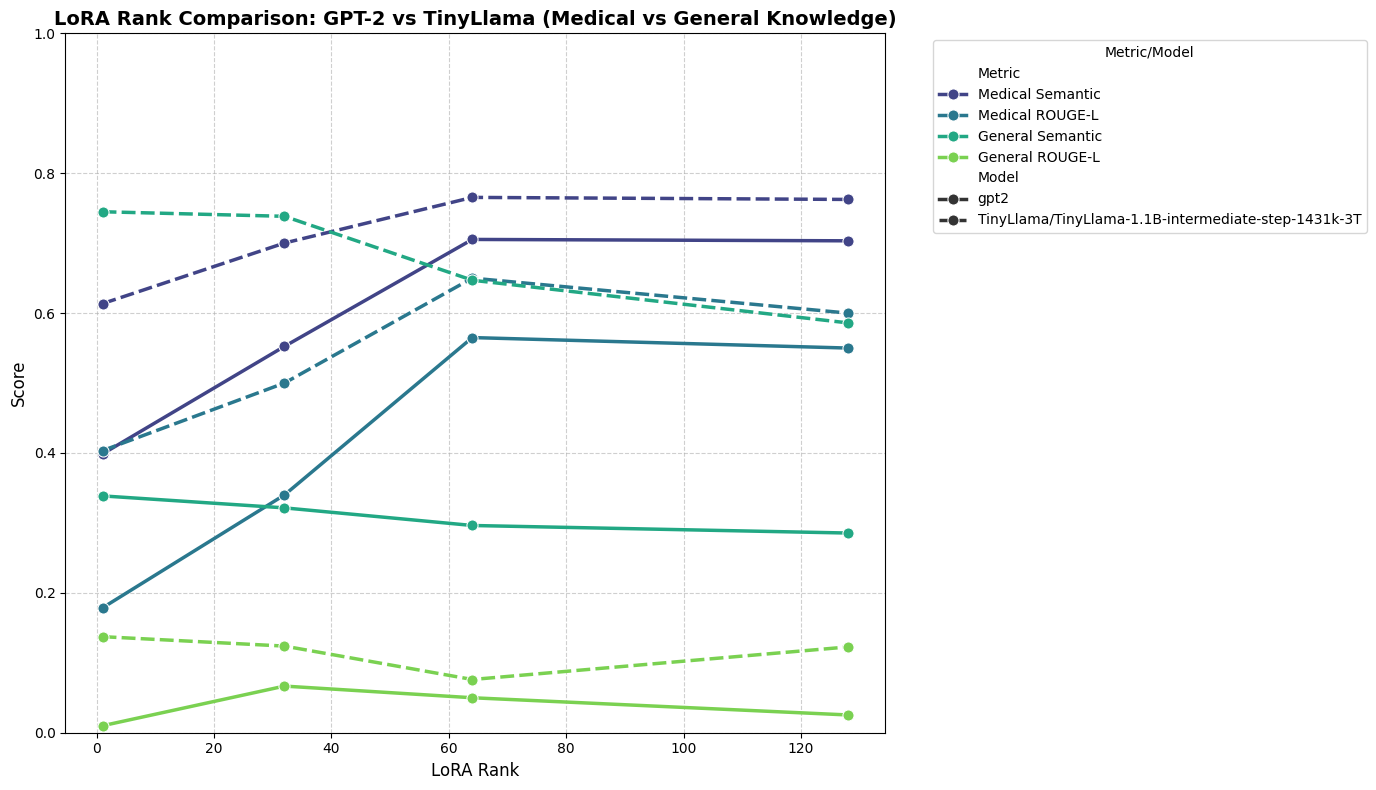


COMBINED LEARNING RATE RESULTS:
                                               Model  Learning Rate  \
0                                               gpt2        0.00001   
1                                               gpt2        0.00010   
2                                               gpt2        0.00030   
3                                               gpt2        0.00050   
4  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00001   
5  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00010   
6  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00030   
7  TinyLlama/TinyLlama-1.1B-intermediate-step-143...        0.00050   

   Medical Semantic  Medical ROUGE-L  General Semantic  General ROUGE-L  
0          0.343615         0.070000          0.362192         0.000000  
1          0.434557         0.091667          0.336421         0.085476  
2          0.525067         0.320000          0.280575         0.070833  
3          0.557277         0.3

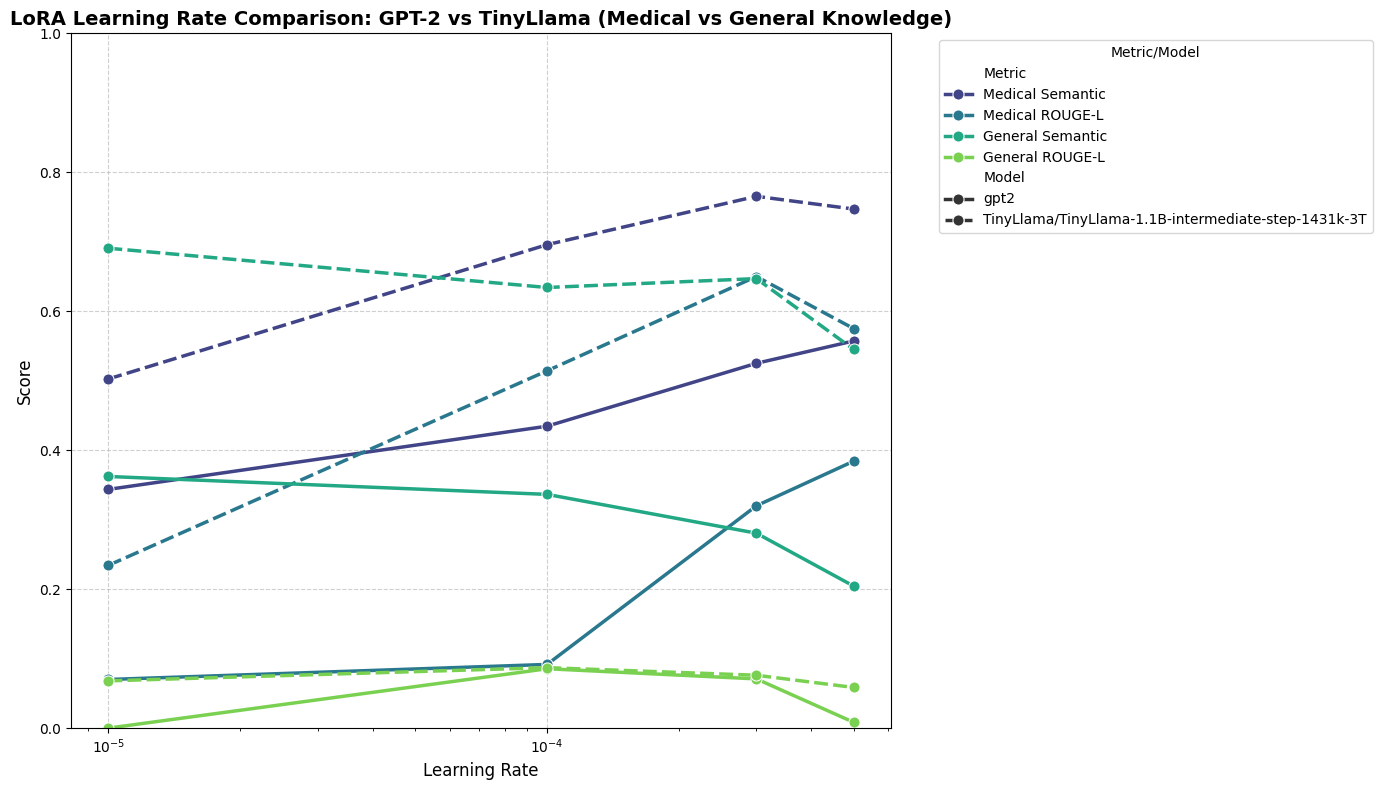


COMBINED EPOCH RESULTS:
                                               Model  Epochs  \
0                                               gpt2       1   
1                                               gpt2       2   
2                                               gpt2       3   
3                                               gpt2       5   
4  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       1   
5  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       2   
6  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       3   
7  TinyLlama/TinyLlama-1.1B-intermediate-step-143...       5   

   Medical Semantic  Medical ROUGE-L  General Semantic  General ROUGE-L  
0          0.446498         0.136667          0.354765         0.050000  
1          0.438518         0.131111          0.325619         0.069643  
2          0.478384         0.247778          0.232235         0.050000  
3          0.593715         0.395000          0.249010         0.000000  
4          0.645600         

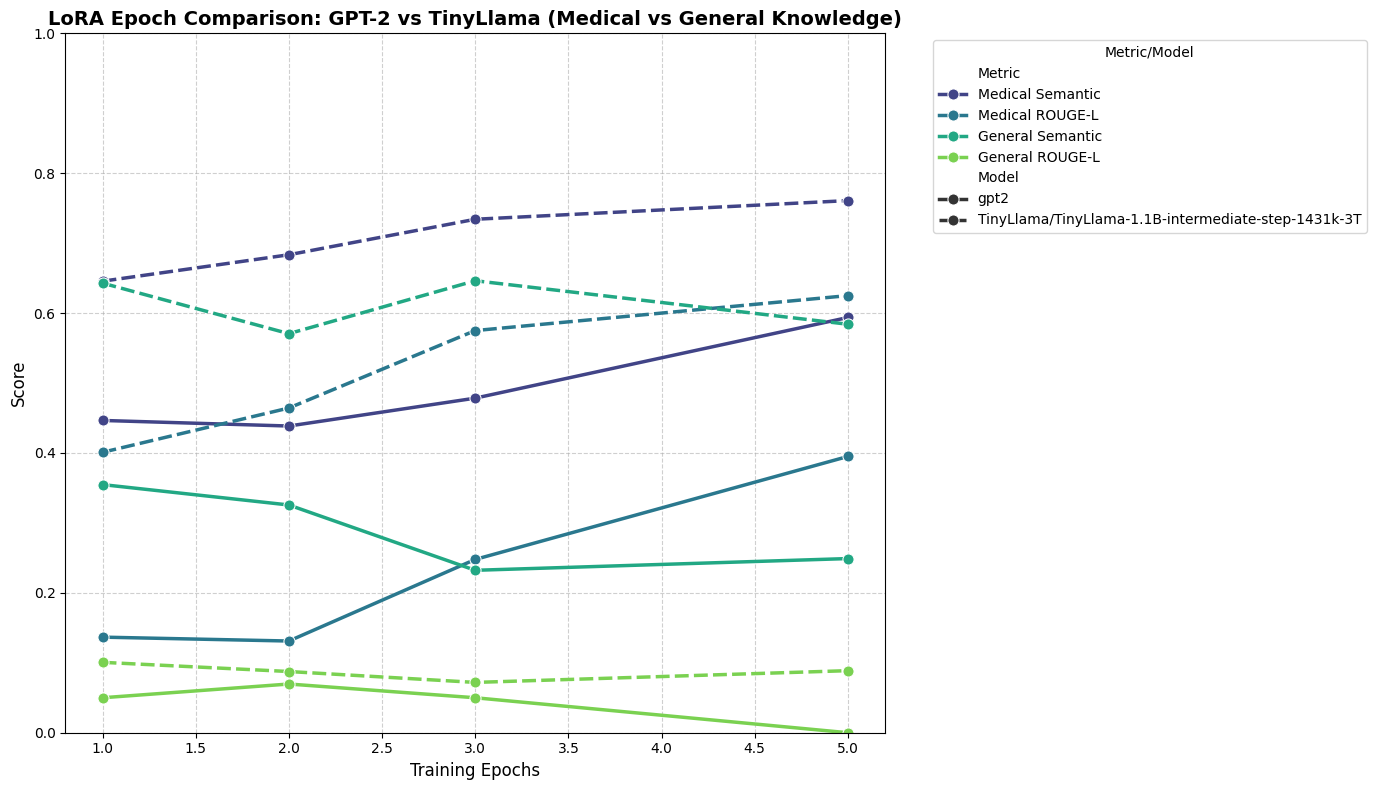


ALL EXPERIMENTS COMPLETED!


In [ ]:
# =========================================================
# Execution
# =========================================================
if __name__ == "__main__":
    models_to_test = ['gpt2', 'TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T']

    all_rank_results = []
    all_lr_results = []
    all_epoch_results = []

    for model_name in models_to_test:
        print(f"\n{'='*80}")
        print(f"STARTING EXPERIMENTS FOR MODEL: {model_name}")
        print(f"{'='*80}\n")

        try:
            runner = LoRAExperiment(model_name=model_name)

            # LoRA rank sweep
            print(f"\n{'#'*80}")
            print(f"RANK EXPERIMENT - {model_name.upper()}")
            print(f"{'#'*80}")
            df_rank = runner.train_and_evaluate(ranks=[1, 32, 64, 128])
            if df_rank is not None:
                all_rank_results.append(df_rank)
                print(f"\n{model_name} Rank Results:")
                print(df_rank)

            # Learning rate sweep
            print(f"\n{'#'*80}")
            print(f"LEARNING RATE EXPERIMENT - {model_name.upper()}")
            print(f"{'#'*80}")
            df_lr = runner.train_and_evaluate_lr(learning_rates=[1e-5, 1e-4, 3e-4, 5e-4])
            if df_lr is not None:
                all_lr_results.append(df_lr)
                print(f"\n{model_name} Learning Rate Results:")
                print(df_lr)

            # Training epoch sweep
            print(f"\n{'#'*80}")
            print(f"EPOCH EXPERIMENT - {model_name.upper()}")
            print(f"{'#'*80}")
            df_epoch = runner.train_and_evaluate_epochs(training_epochs=[1, 2, 3, 5])
            if df_epoch is not None:
                all_epoch_results.append(df_epoch)
                print(f"\n{model_name} Epoch Results:")
                print(df_epoch)

        except Exception as e:
            print(f"Error running experiments for {model_name}: {e}")
            print("Skipping this model and continuing...")
            continue

    # Combining all the results and generating the plots

    # Rank Results
    if all_rank_results:
        df_rank_combined = pd.concat(all_rank_results, ignore_index=True)
        print("\n" + "="*80)
        print("COMBINED RANK RESULTS:")
        print("="*80)
        print(df_rank_combined)

        plt.figure(figsize=(14, 8))
        plot_data = pd.melt(df_rank_combined, id_vars=['Model', 'Rank'], var_name='Metric', value_name='Score')

        # Creating separate plots for each metric or combine with model distinction
        sns.lineplot(data=plot_data, x='Rank', y='Score', hue='Metric', style='Model',
                    marker='o', palette='viridis', linewidth=2.5, markersize=8)
        plt.title('LoRA Rank Comparison: GPT-2 vs TinyLlama (Medical vs General Knowledge)', fontsize=14, fontweight='bold')
        plt.ylabel('Score', fontsize=12)
        plt.xlabel('LoRA Rank', fontsize=12)
        plt.ylim(0, 1.0)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Metric/Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # Learning Rate Results
    if all_lr_results:
        df_lr_combined = pd.concat(all_lr_results, ignore_index=True)
        print("\n" + "="*80)
        print("COMBINED LEARNING RATE RESULTS:")
        print("="*80)
        print(df_lr_combined)

        plt.figure(figsize=(14, 8))
        plot_data = pd.melt(df_lr_combined, id_vars=['Model', 'Learning Rate'], var_name='Metric', value_name='Score')

        sns.lineplot(data=plot_data, x='Learning Rate', y='Score', hue='Metric', style='Model',
                    marker='o', palette='viridis', linewidth=2.5, markersize=8)
        plt.title('LoRA Learning Rate Comparison: GPT-2 vs TinyLlama (Medical vs General Knowledge)',
                 fontsize=14, fontweight='bold')
        plt.ylabel('Score', fontsize=12)
        plt.xlabel('Learning Rate', fontsize=12)
        plt.xscale('log')
        plt.ylim(0, 1.0)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Metric/Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # Epoch Results
    if all_epoch_results:
        df_epoch_combined = pd.concat(all_epoch_results, ignore_index=True)
        print("\n" + "="*80)
        print("COMBINED EPOCH RESULTS:")
        print("="*80)
        print(df_epoch_combined)

        plt.figure(figsize=(14, 8))
        plot_data = pd.melt(df_epoch_combined, id_vars=['Model', 'Epochs'], var_name='Metric', value_name='Score')

        sns.lineplot(data=plot_data, x='Epochs', y='Score', hue='Metric', style='Model',
                    marker='o', palette='viridis', linewidth=2.5, markersize=8)
        plt.title('LoRA Epoch Comparison: GPT-2 vs TinyLlama (Medical vs General Knowledge)',
                 fontsize=14, fontweight='bold')
        plt.ylabel('Score', fontsize=12)
        plt.xlabel('Training Epochs', fontsize=12)
        plt.ylim(0, 1.0)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(title='Metric/Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED!")
    print("="*80)